In [2]:
import sys

import os
import matplotlib.pyplot as plt 
import numpy as np
sys.path.append(os.path.abspath('../src'))

In [2]:
from load_utils import load_step_data
from utils import plot_raster_simple


In [3]:
step_data = load_step_data(
    base_dir='../src/save/ER_dense_stdp',
    step=2,
    arrays=['base_S_hist','pruned_S_hist_batch', 'removed_ids', 'neuron_type'])


(<Figure size 1440x450 with 1 Axes>,
 <Axes: xlabel='Time (ms)', ylabel='Neuron ID'>)

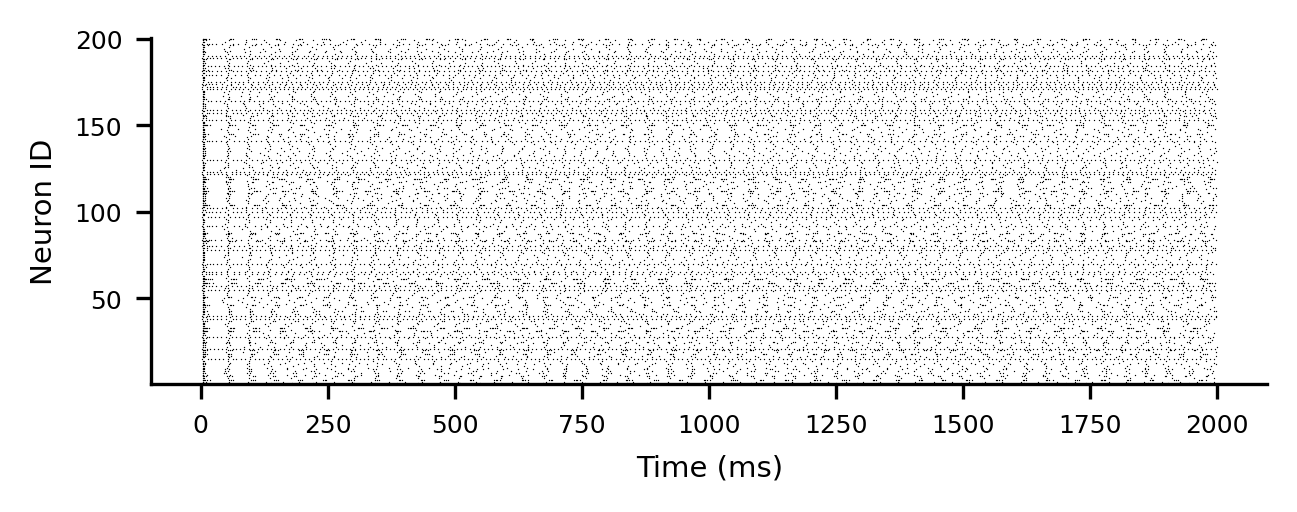

In [4]:
plot_raster_simple(step_data['arrays']['base_S_hist'], 2000, title='', apply_style=True)

In [5]:
import numpy as np

def keep_indices(remove_idx: np.ndarray, N: int) -> np.ndarray:
    """Return fixed-size (N-k,) indices to keep. O(N)."""
    k = remove_idx.shape[0]
    # mask: True for keep, False for remove
    mask = np.ones((N,), dtype=bool)
    mask[remove_idx] = False
    # Grab exactly N-k kept indices, preserving order (left→right).
    keep_idx = np.nonzero(mask)[0]  # (N-k,)
    return keep_idx

def _take_vec(x: np.ndarray, idx: np.ndarray) -> np.ndarray:
    return np.take(x, idx, axis=0)

def _take_square(M: np.ndarray, idx: np.ndarray) -> np.ndarray:
    M1 = np.take(M, idx, axis=0)
    M2 = np.take(M1, idx, axis=1)
    return M2

In [6]:

im_args = {"approach": "miller_madow", "base": 2}
batch = 0
fraction = 0.33
N = step_data['metadata']['parameters']['N']


In [7]:
surviving_nodes = keep_indices(step_data['arrays']['removed_ids'][batch], N)

# Build data matrix
A = step_data['arrays']['base_S_hist']
A = A[:, surviving_nodes]
B = step_data['arrays']['pruned_S_hist_batch'][batch]
A = np.concatenate([A, B], axis=0)

In [8]:
A

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(16000, 180))

(<Figure size 1440x450 with 1 Axes>,
 <Axes: xlabel='Time (ms)', ylabel='Neuron ID'>)

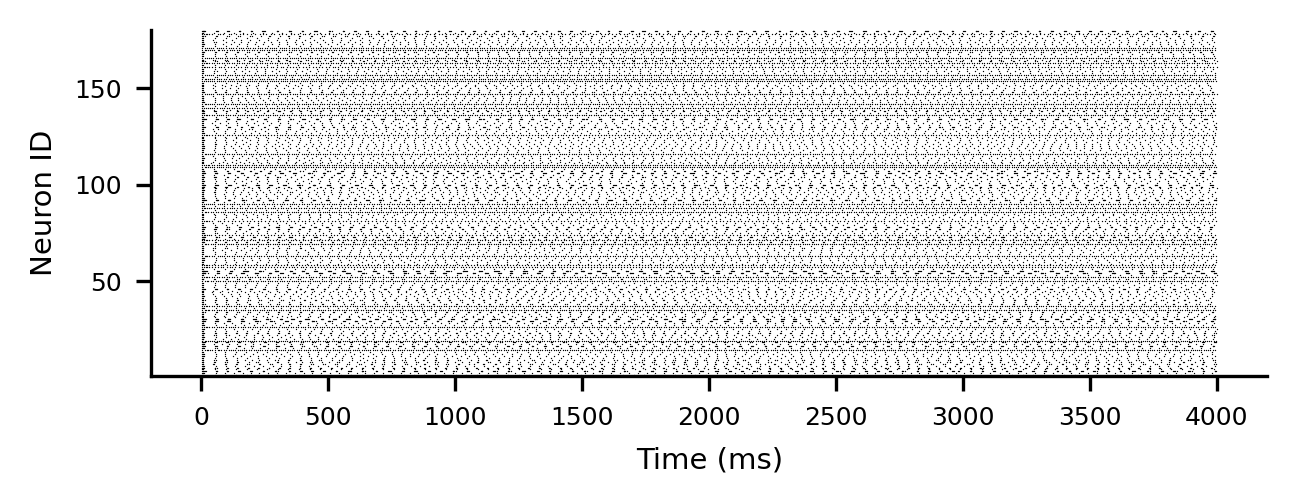

In [9]:
plot_raster_simple(A, 4000, title='', apply_style=True)

(<Figure size 1440x450 with 1 Axes>,
 <Axes: xlabel='Time (ms)', ylabel='Neuron ID'>)

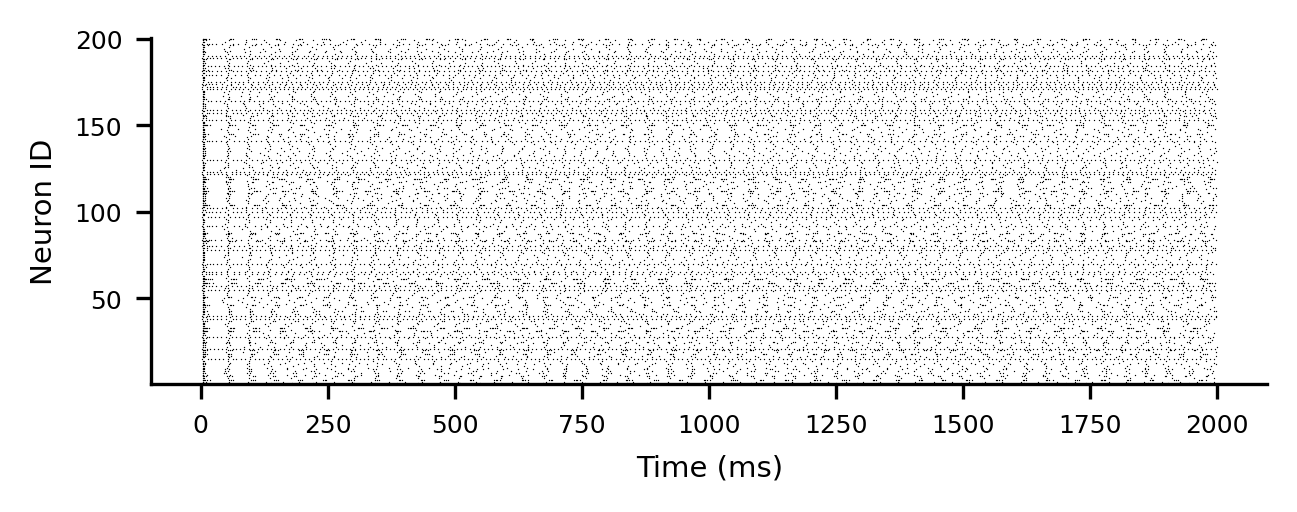

In [10]:
plot_raster_simple(step_data['arrays']['base_S_hist'], 2000, title='', apply_style=True)

In [11]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process


def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float
        Initial values in three dimensional space.
    angular_frequency : float
        Angular frequency in 1/ms.

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))


def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,
                      sigma=10, rho=28, beta=2.667, tau=1e3):
    """

    Parameters
    ----------
    dt :
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0, z0 : float
        Initial values in three dimensional space
    sigma, rho, beta : float
        Parameters defining the lorenz attractor
    tau : characteristic timescale in ms

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (3, num_steps) np.ndarray
        Integrated three-dimensional trajectory (x, y, z) of the Lorenz attractor
    """
    def _lorenz_ode(point_of_interest, timepoint, sigma, rho, beta, tau):
        """
        Fit the model with `spiketrains` data and apply the dimensionality
        reduction on `spiketrains`.

        Parameters
        ----------
        point_of_interest : tuple
            Tupel containing coordinates (x,y,z) in three dimensional space.
        timepoint : a point of interest in time
        dt :
            Integration time step in ms.
        num_steps : int
            Number of integration steps -> max_time = dt*(num_steps-1).
        sigma, rho, beta : float
            Parameters defining the lorenz attractor
        tau : characteristic timescale in ms

        Returns
        -------
        x_dot, y_dot, z_dot : float
            Values of the lorenz attractor's partial derivatives
            at the point x, y, z.
        """

        x, y, z = point_of_interest

        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot

    assert isinstance(num_steps, int), "num_steps has to be integer"

    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T


def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep :
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).

    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.

    """

    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

In [12]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 2 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 50
num_spiketrains = 100

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

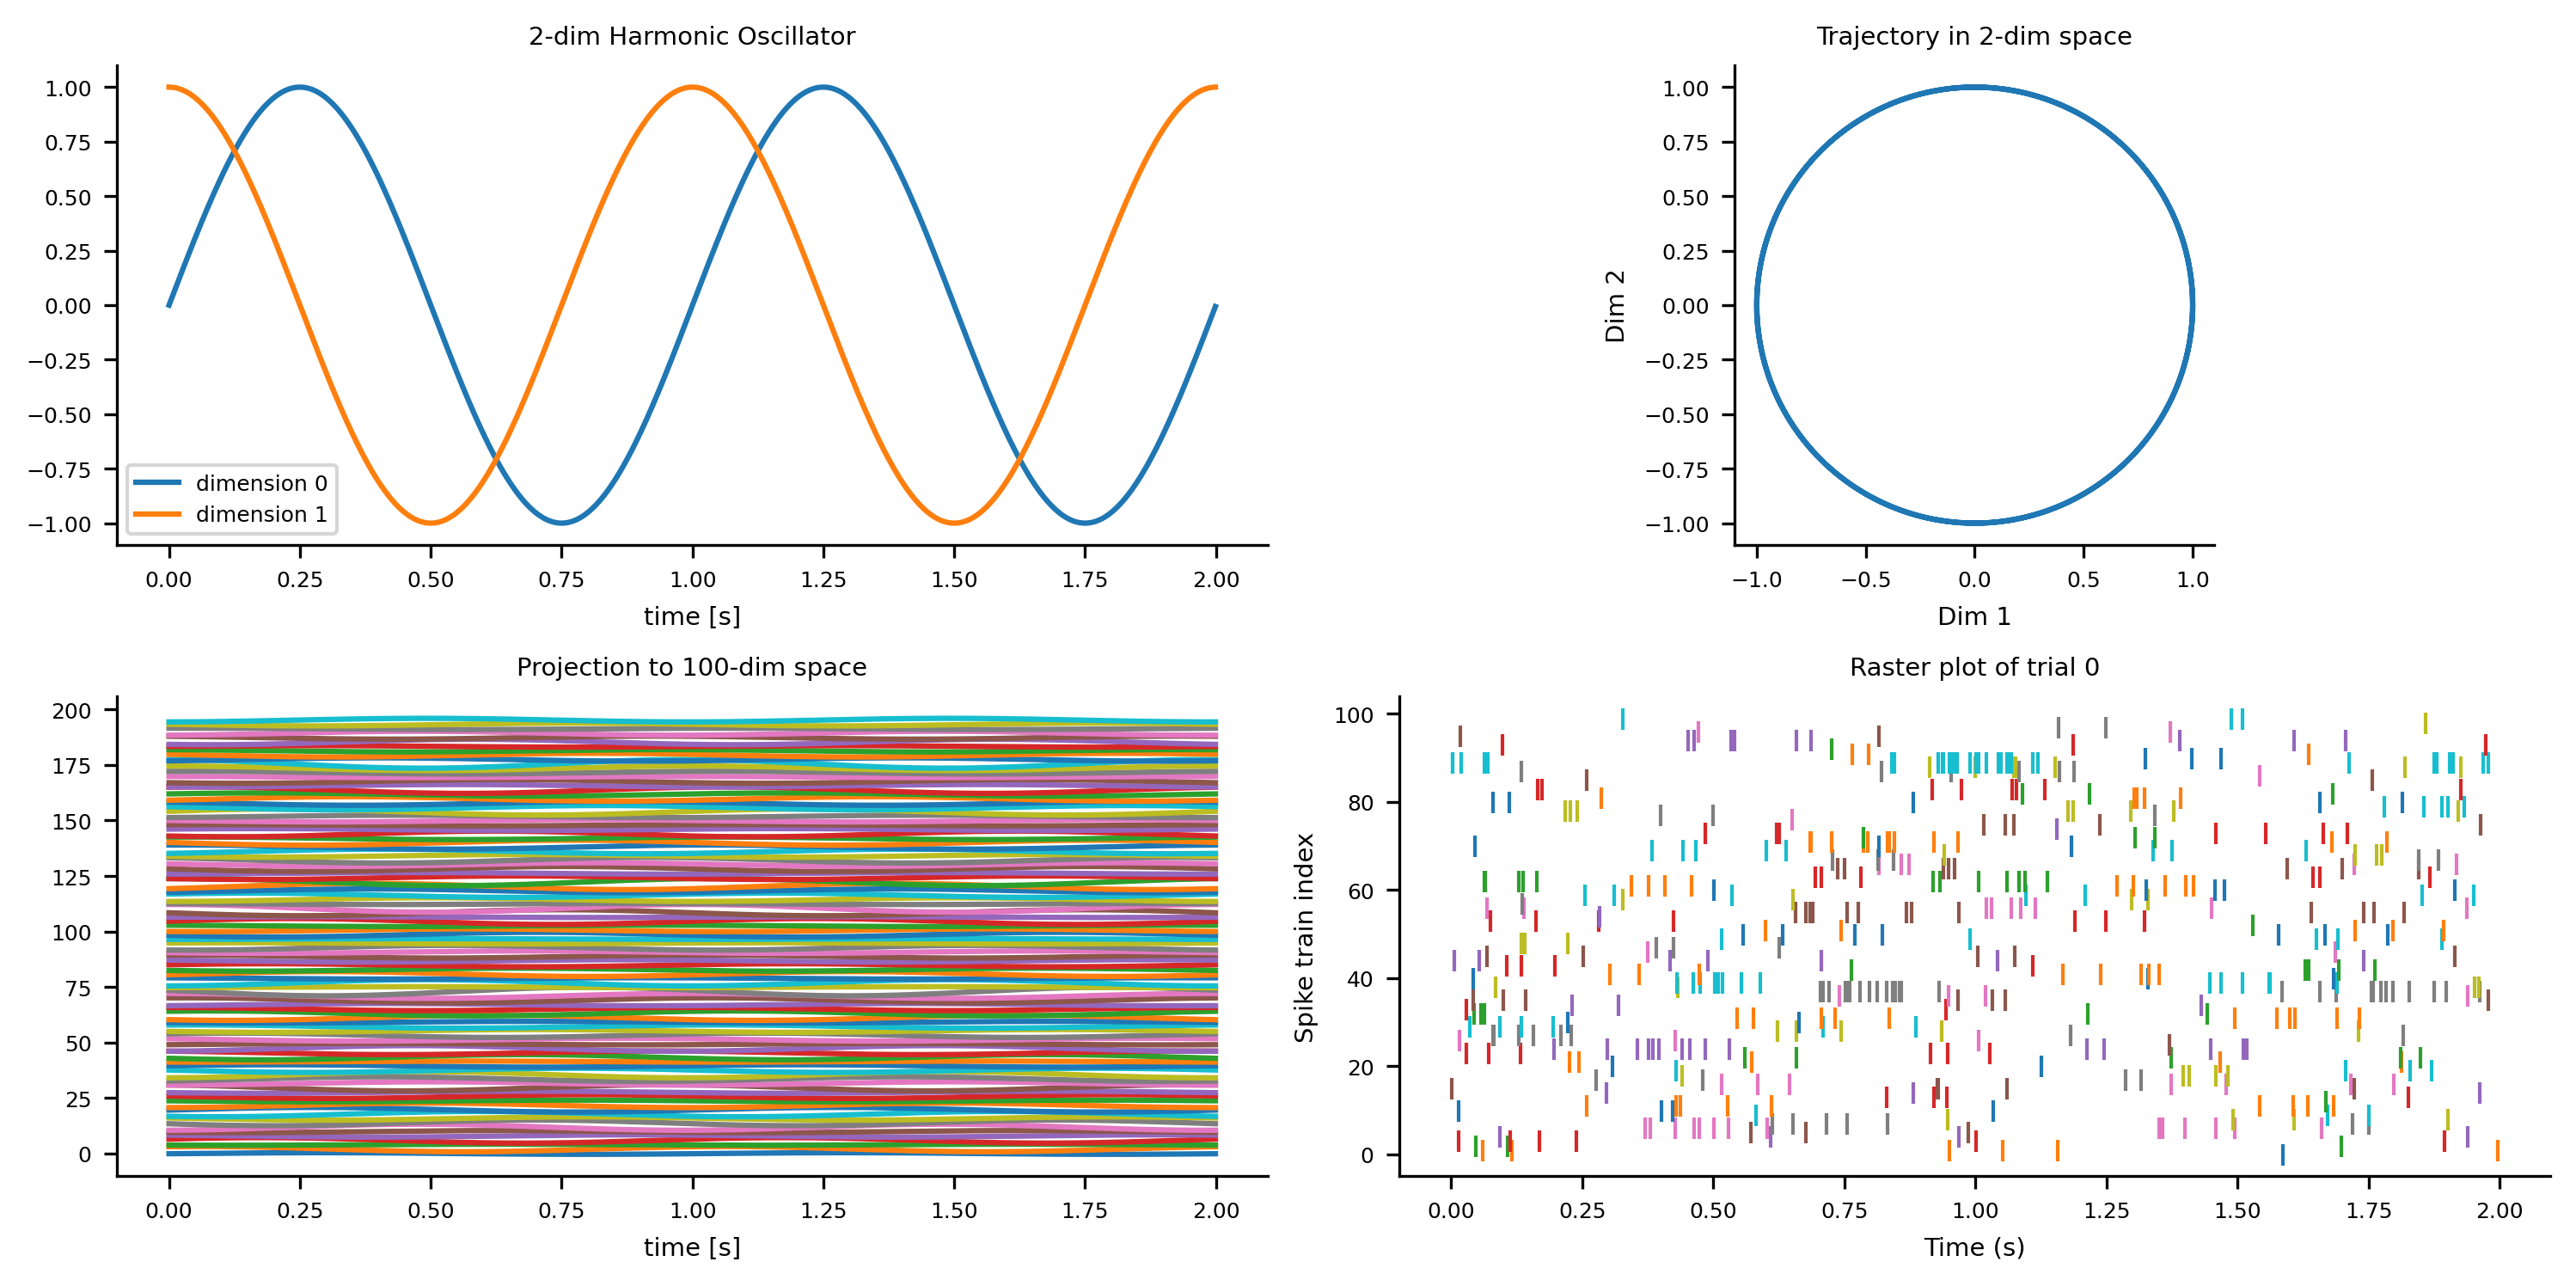

In [13]:
import matplotlib.pyplot as plt


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5))

ax1.set_title('2-dim Harmonic Oscillator')
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i}')
ax1.legend()

ax2.set_title('Trajectory in 2-dim space')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('time [s]')
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [14]:
from elephant.gpfa import GPFA


# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [15]:
from elephant.gpfa import GPFA


# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

gpfa_2dim.fit(spiketrains_oscillator)
print(gpfa_2dim.params_estimated.keys())

trajectories = gpfa_2dim.transform(spiketrains_oscillator[num_trials//2:])


Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


In [16]:
trajectories = gpfa_2dim.transform(spiketrains_oscillator[num_trials//2:])


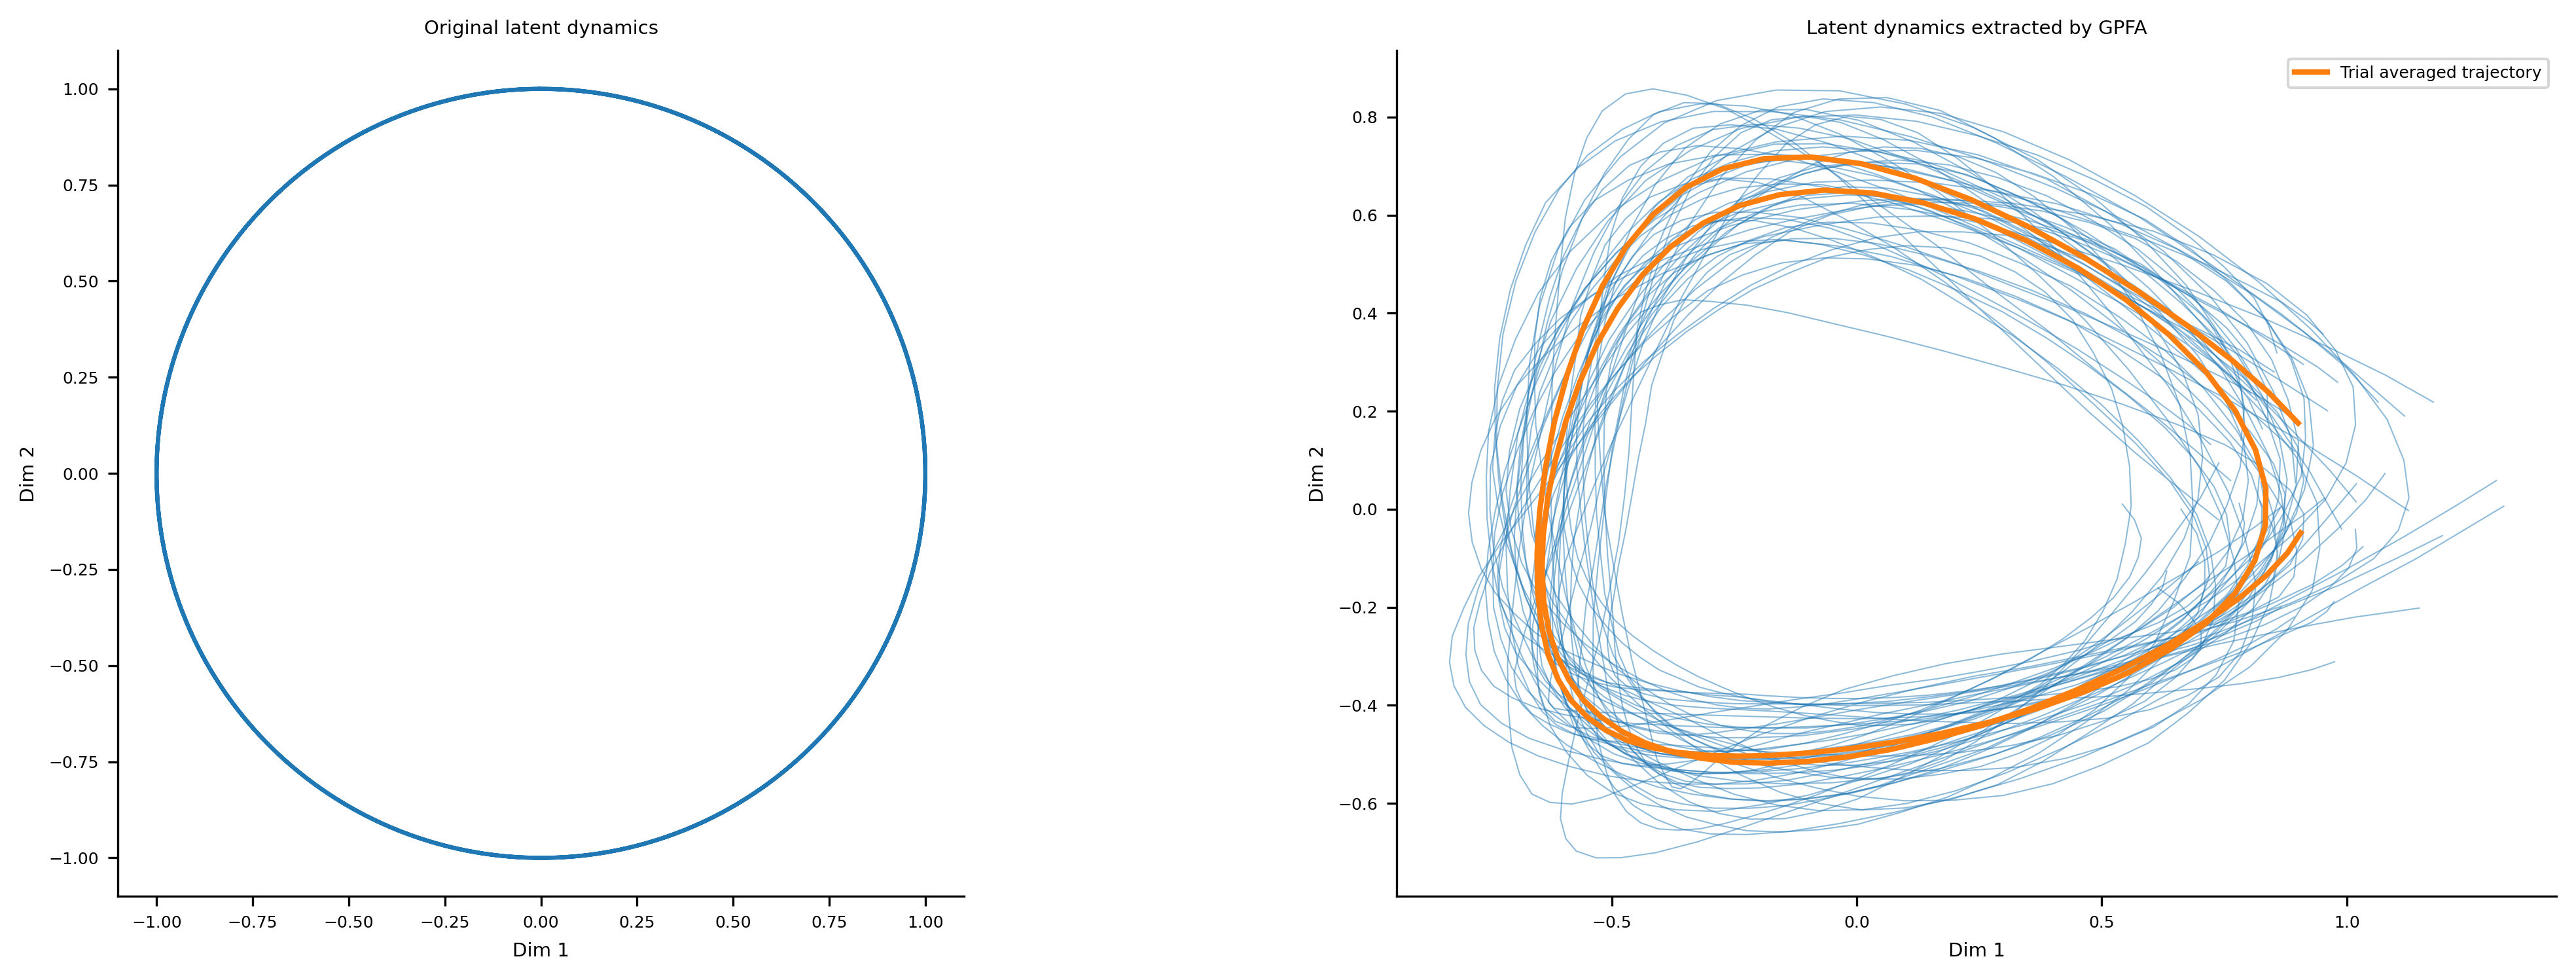

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
ax1.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()

Initializing parameters using factor analysis...

Fitting GPFA model...


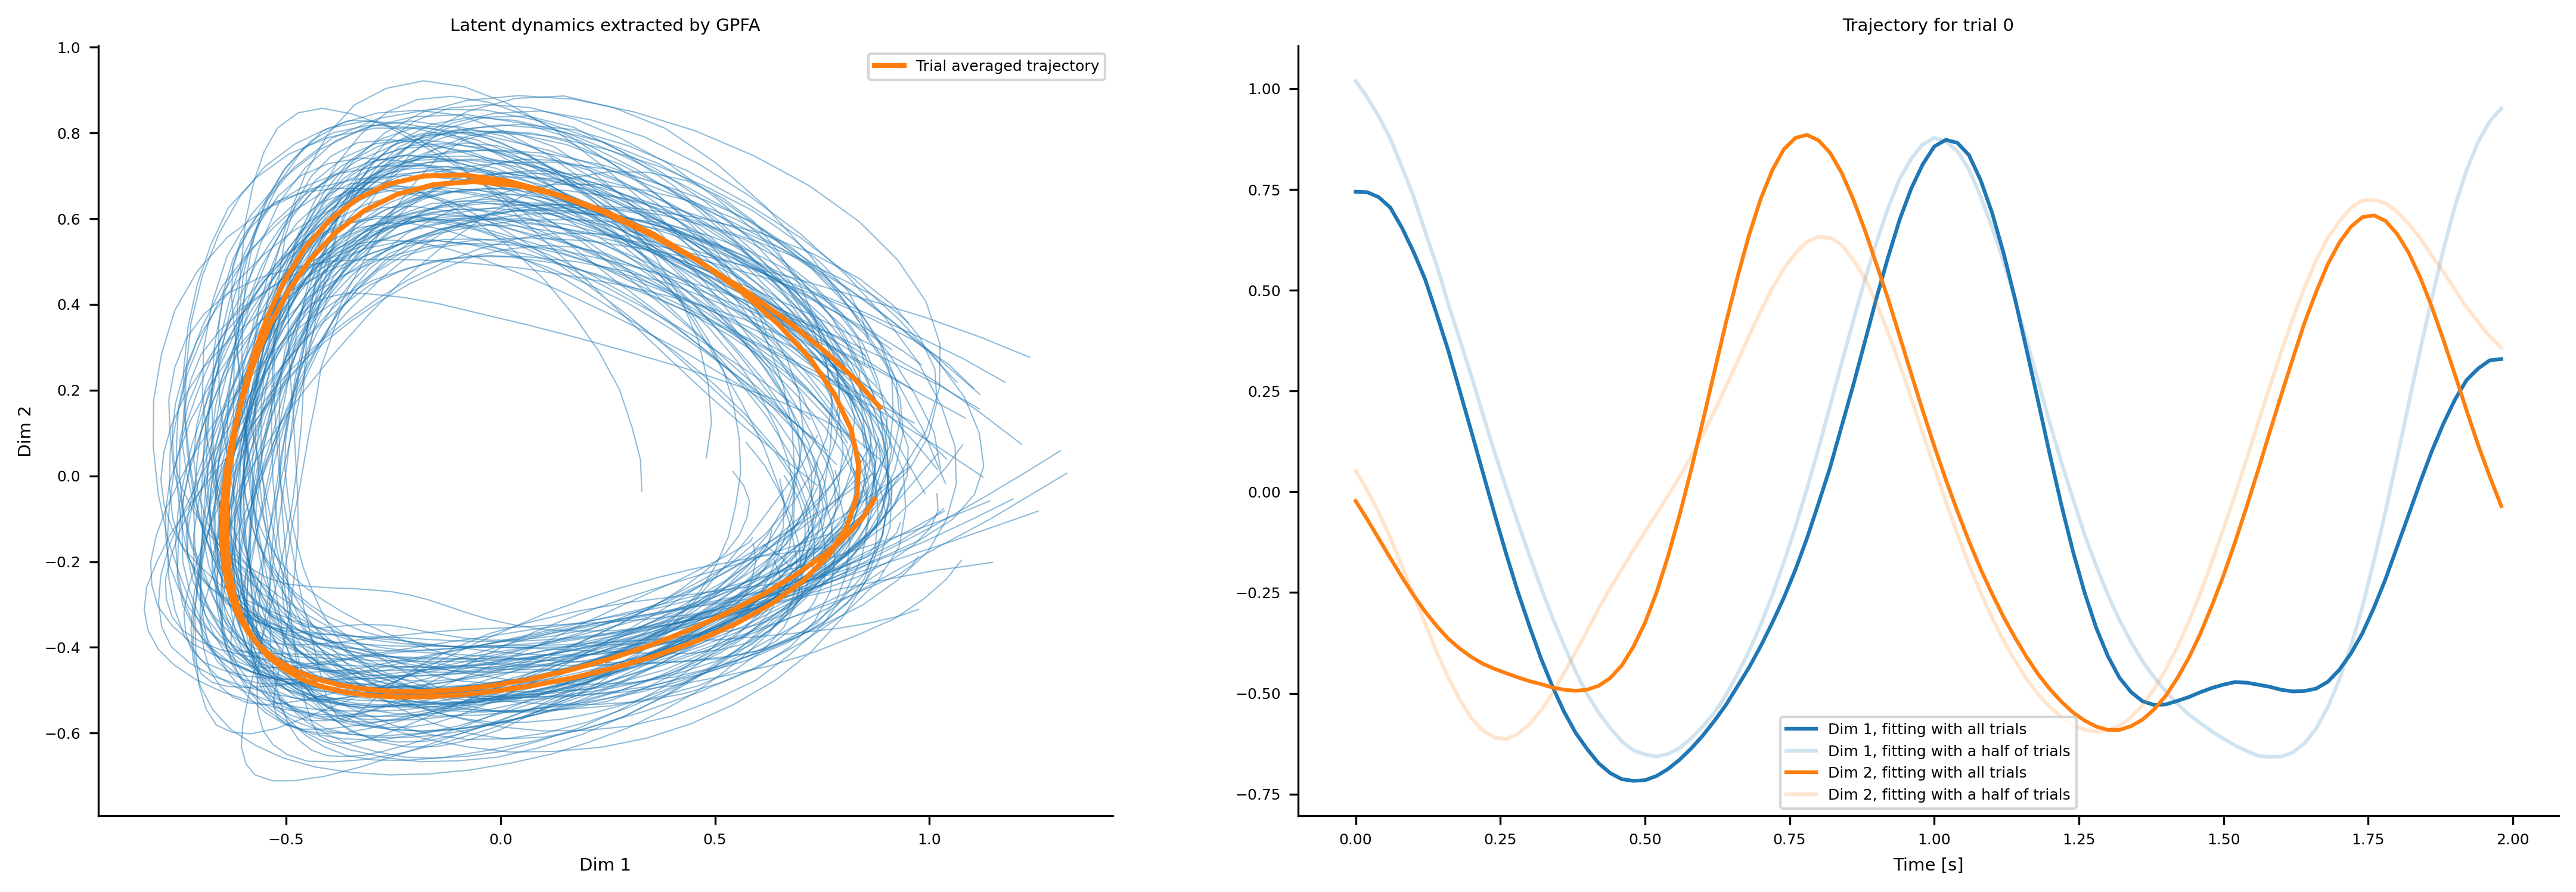

In [18]:
 #here we just reuse the existing instance of the GPFA() class as we use the same fitting parameters as before
trajectories_all = gpfa_2dim.fit_transform(spiketrains_oscillator)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Latent dynamics extracted by GPFA')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
for single_trial_trajectory in trajectories_all:
    ax1.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
average_trajectory = np.mean(trajectories_all, axis=0)
ax1.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax1.legend()

trial_to_plot = 0
ax2.set_title(f'Trajectory for trial {trial_to_plot}')
ax2.set_xlabel('Time [s]')
times_trajectory = np.arange(len(trajectories_all[trial_to_plot][0])) * bin_size.rescale('s')
ax2.plot(times_trajectory, trajectories_all[0][0], c='C0', label="Dim 1, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][0], c='C0', alpha=0.2, label="Dim 1, fitting with a half of trials")
ax2.plot(times_trajectory, trajectories_all[0][1], c='C1', label="Dim 2, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][1], c='C1', alpha=0.2, label="Dim 2, fitting with a half of trials")
ax2.legend()

plt.tight_layout()
plt.show()

In [19]:
from sklearn.model_selection import cross_val_score

x_dims = [1, 2, 3, 4, 5]
log_likelihoods = []
for x_dim in x_dims:
    gpfa_cv = GPFA(x_dim=x_dim)
    # estimate the log-likelihood for the given dimensionality as the mean of the log-likelihoods from 3 cross-vailidation folds
    cv_log_likelihoods = cross_val_score(gpfa_cv, spiketrains_oscillator, cv=3, n_jobs=3, verbose=True)
    log_likelihoods.append(np.mean(cv_log_likelihoods))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initializing parameters using factor analysis...
Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...

Fitting GPFA model...
Fitting has converged after 245 EM iterations.)
Fitting has converged after 260 EM iterations.)
Fitting has converged after 255 EM iterations.)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.4s finished


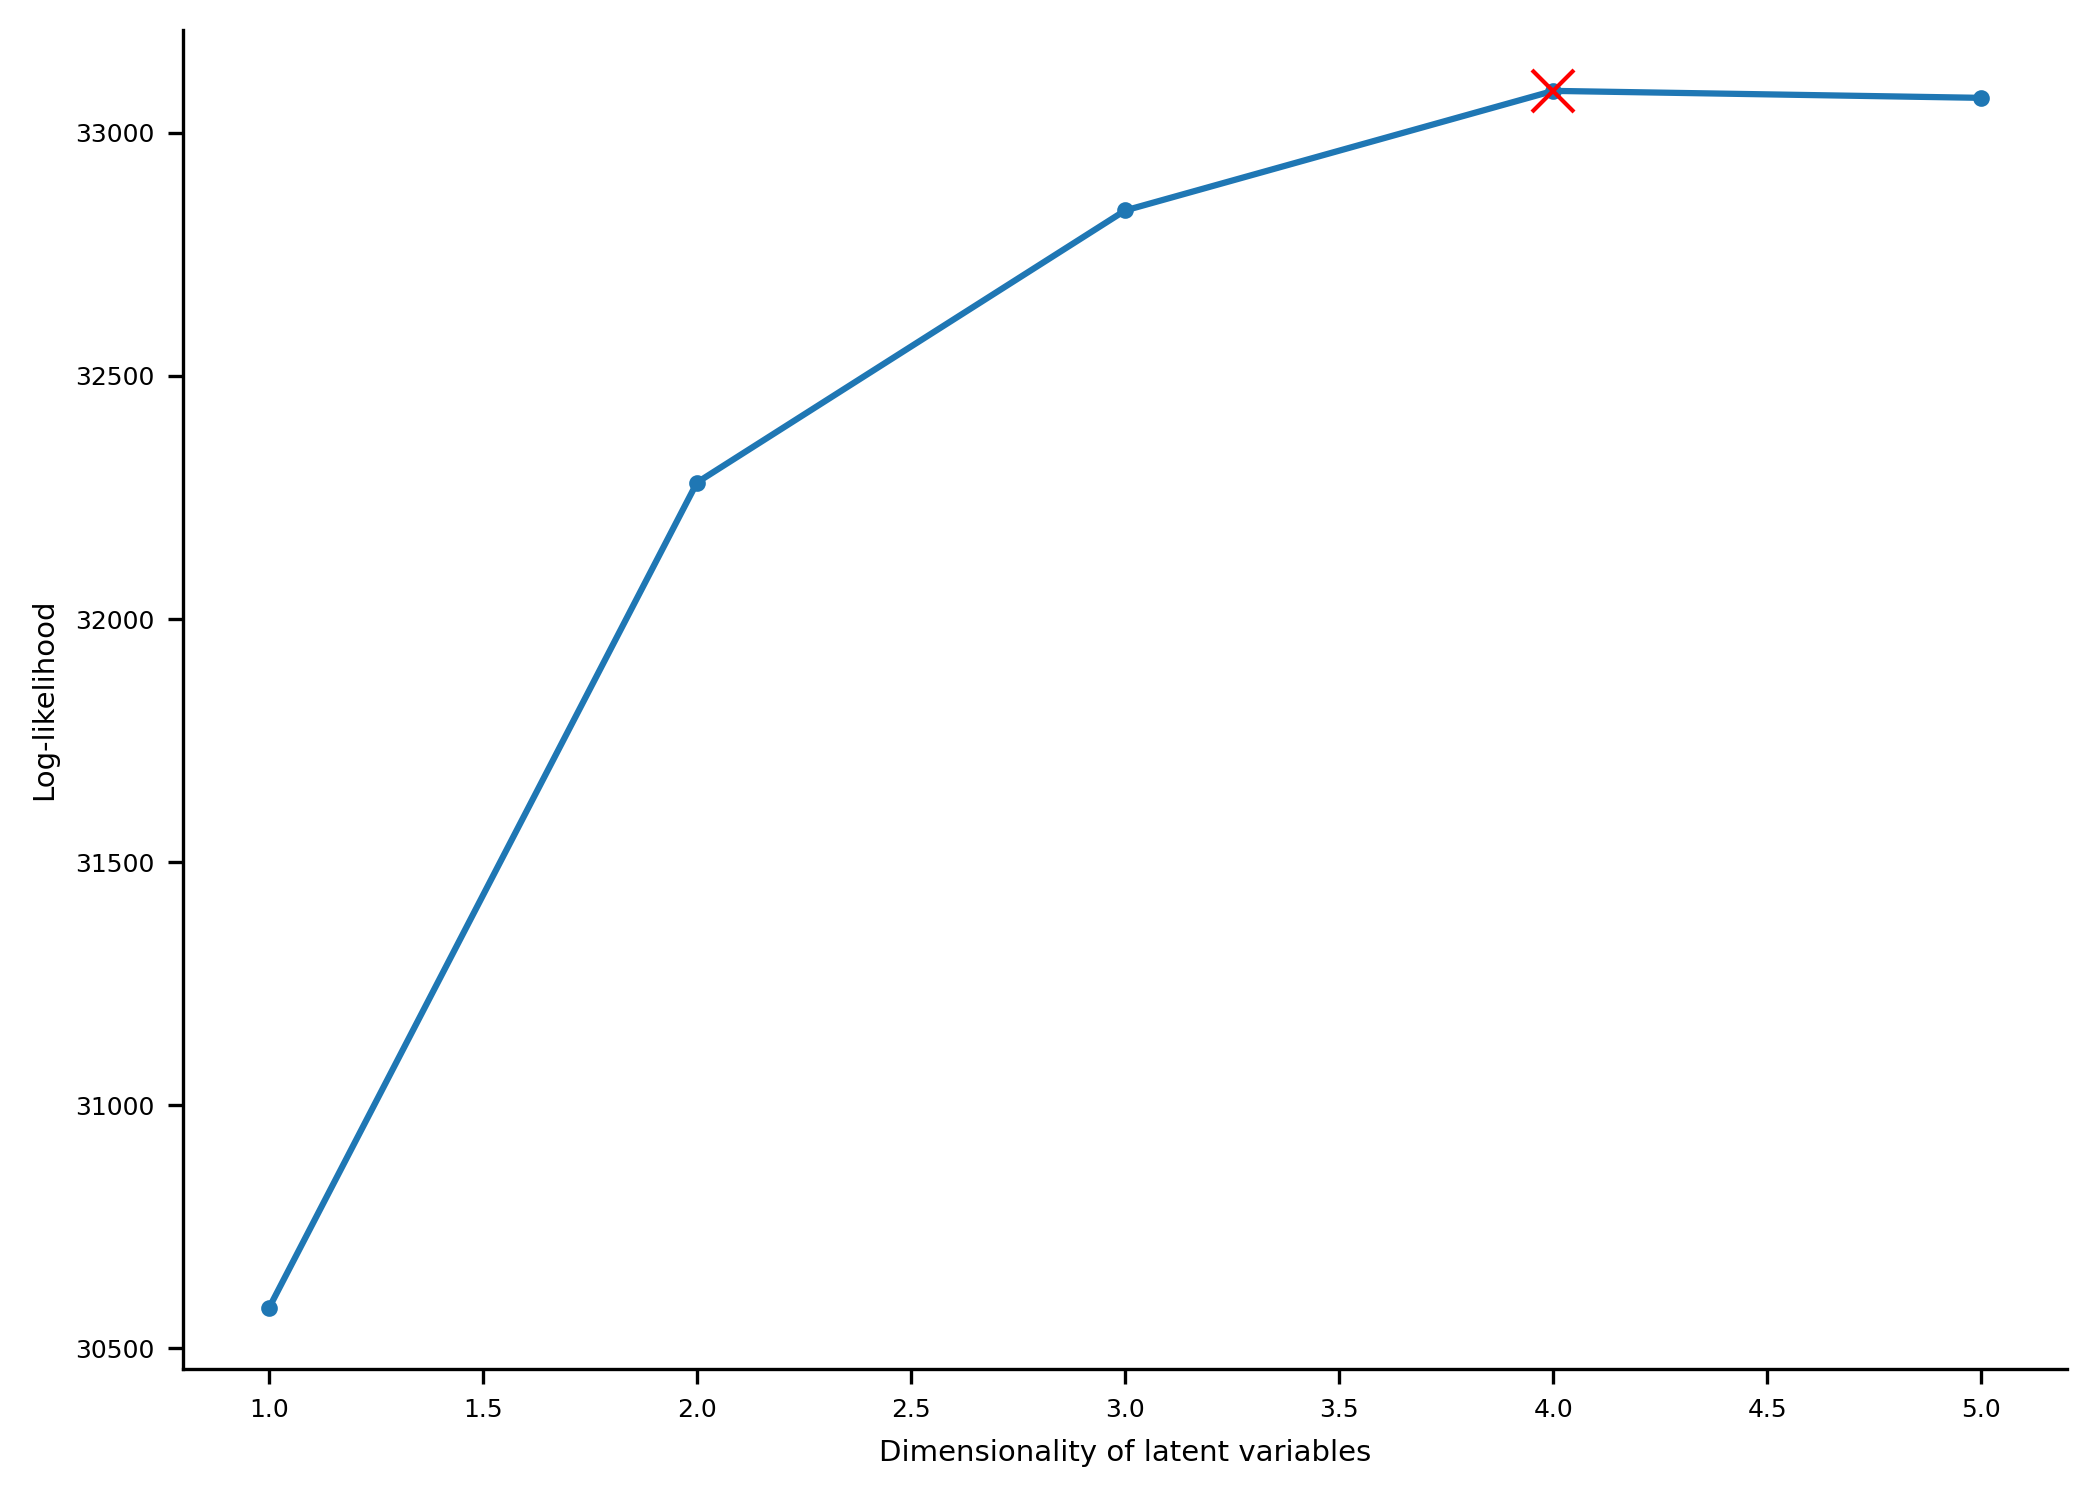

In [20]:
f = plt.figure(figsize=(7, 5))
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
plt.plot(x_dims, log_likelihoods, '.-')
plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import quantities as pq
from neo.core import SpikeTrain

def convert_to_spiketrains(S, dt=0.25, T=1000):
    """
    Convert a binary spike matrix into Elephant/Neo SpikeTrain objects.

    Parameters
    ----------
    S : np.ndarray
        Binary spike matrix of shape (time_steps, n_neurons).
        Each entry is 0 (no spike) or 1 (spike).
    dt : float
        Time step in ms (default 0.25).
    T : float
        Total duration in ms (default 1000).

    Returns
    -------
    list of neo.core.SpikeTrain
        One SpikeTrain per neuron.
    """
    n_neurons = S.shape[1]
    spiketrains = []
    
    for n in range(n_neurons):
        spike_indices = np.where(S[:, n] == 1)[0]
        spike_times = spike_indices * dt * pq.ms
        st = SpikeTrain(times=spike_times,
                        t_start=0*pq.ms,
                        t_stop=T*pq.ms)
        spiketrains.append(st)
    
    return spiketrains

In [16]:
spike_train_base = step_data['arrays']['base_S_hist']
spkt_base = convert_to_spiketrains(spike_train_base.astype(np.int32), T=2000)

In [18]:
from elephant.gpfa import GPFA

spkt_base = [convert_to_spiketrains(spike_train_base.astype(np.int32), T=2000)]
# specify fitting parameters
bin_size = 10 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

gpfa_2dim.fit(spkt_base)
print(gpfa_2dim.params_estimated.keys())

trajectories = gpfa_2dim.transform(spkt_base)


ValueError: Observation covariance matrix is rank deficient.
Possible causes: repeated units, not enough observations.

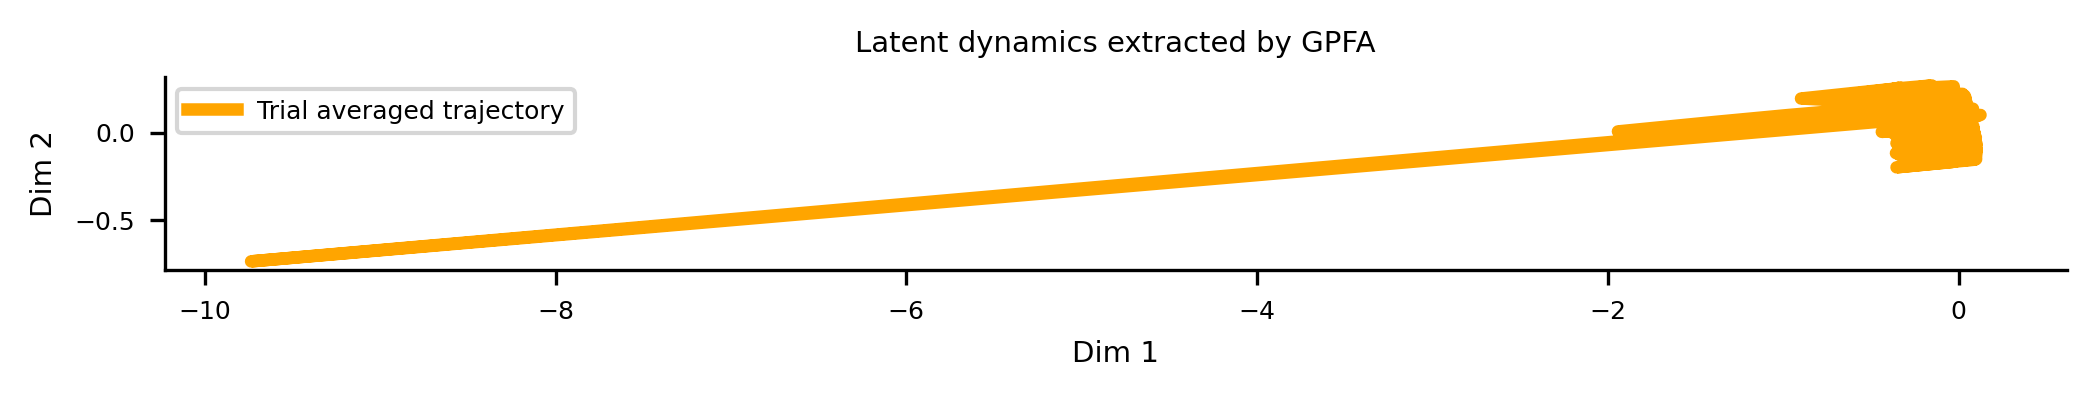

In [95]:
fig, ax2 = plt.subplots(1, 1, figsize=(7, 5))
ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()

In [4]:
from networks import run_single_network, create_random_network
from utils import plot_raster, plot_adjacency_matrix


In [85]:
neurons, G = create_random_network(N=600, p_connect=0.01, weight_bounds=(0.1,5))

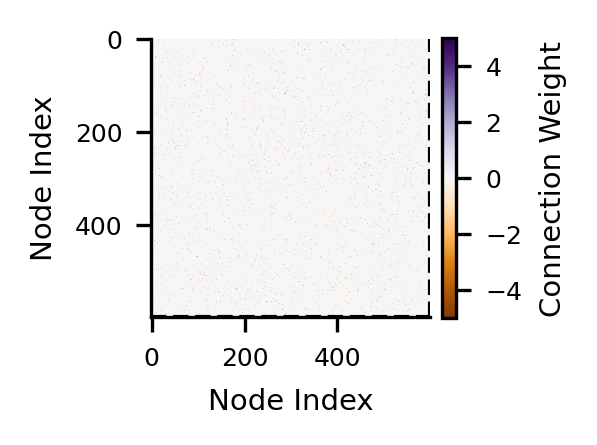

In [86]:
plot_adjacency_matrix(G, figsize=(2,2))
plt.show()

In [96]:
T_seconds = 4
T =int( T_seconds* 1000)
trials = []
for trial in range(10):
    V_hist, S_hist, I_syn_hist, I_ext, final_state, final_stdp_state = run_single_network(
    neurons, G, network_type='stdp_syn', T=T, nkey=32 +trial)
    trials.append(S_hist)



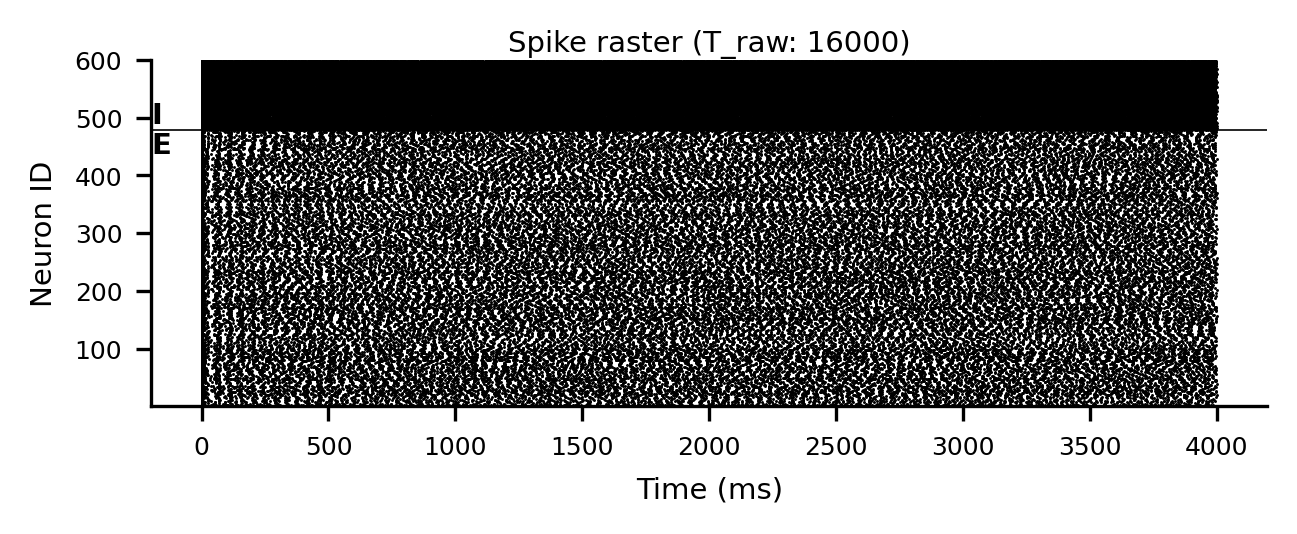

In [97]:
plot_raster(S_hist, neurons, final_state.W, T_total=T, title=f'Spike raster (T_raw: {int(T/0.25)})')
plt.show()

In [137]:
16000//3

5333

In [147]:
# s0 = S_hist.shape[0]
# S_fraction = S_hist[-s0//3:,:]
# S_fraction.shape
fraction_trials = []
for t in trials:
    s0 = t.shape[0]
    S_fraction = t[-s0//3:,:]
    fraction_trials.append(S_fraction)


In [148]:
from elephant.gpfa import GPFA

spkt_base = [convert_to_spiketrains(spike_train_base.astype(np.int32), T=T) for spike_train_base in fraction_trials]
# specify fitting parameters
bin_size = 0.5 * pq.ms
latent_dimensionality = 3

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

gpfa_2dim.fit(spkt_base)
print(gpfa_2dim.params_estimated.keys())

trajectories = gpfa_2dim.transform(spkt_base)

Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


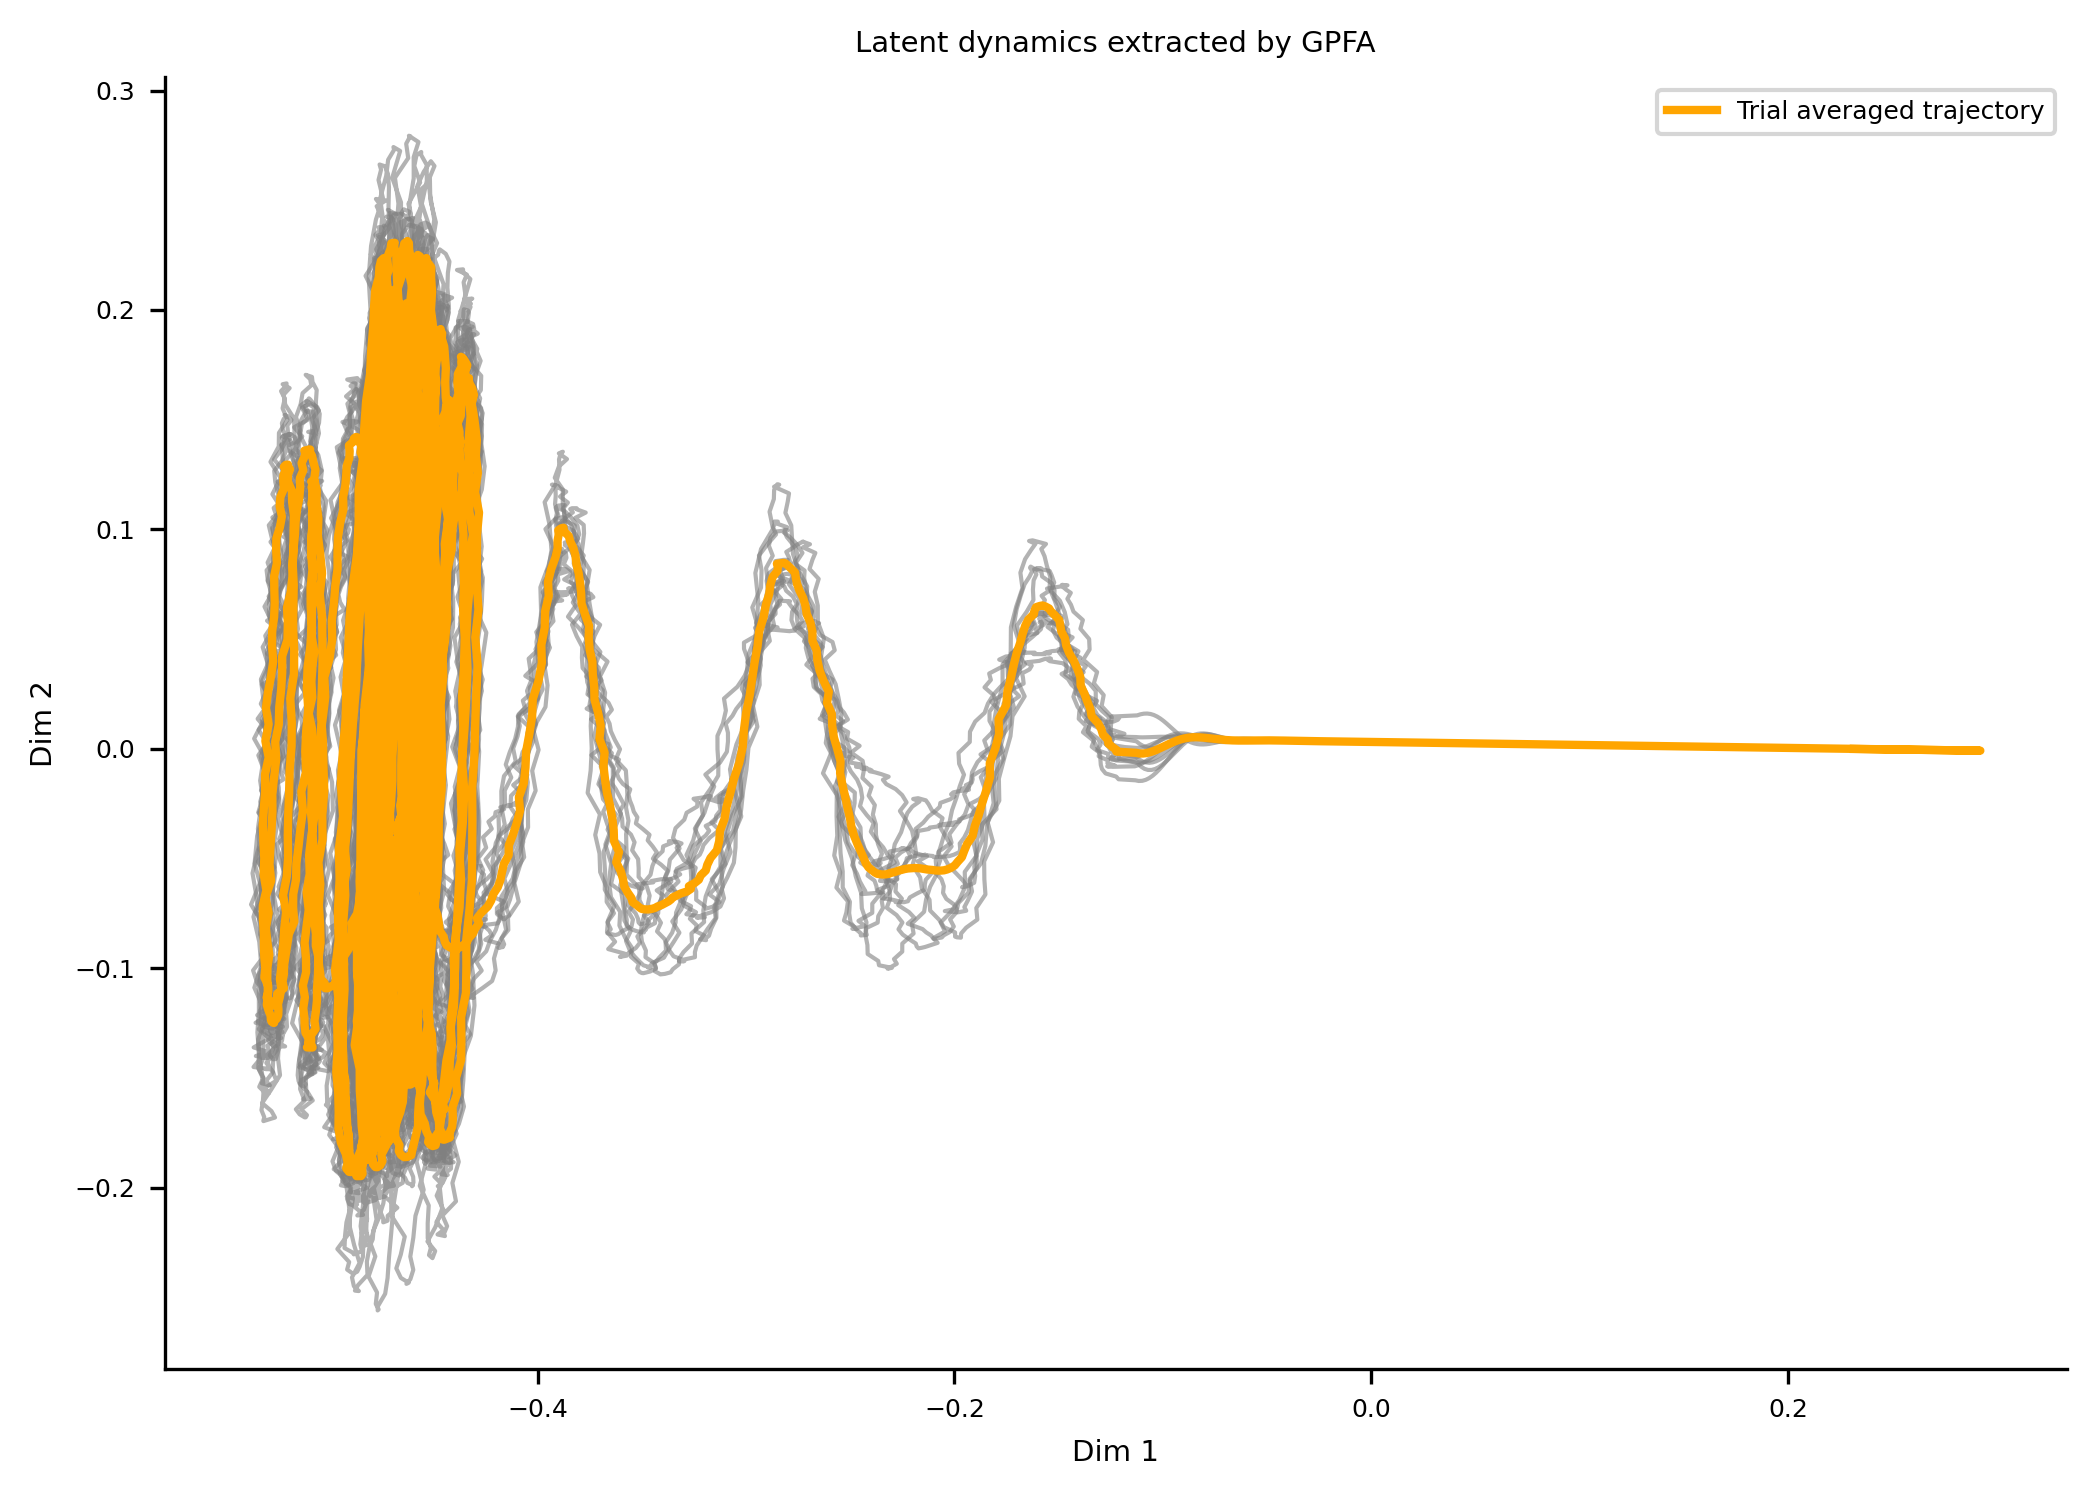

In [149]:
fig, ax2 = plt.subplots(1, 1, figsize=(7, 5))
ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
#ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()

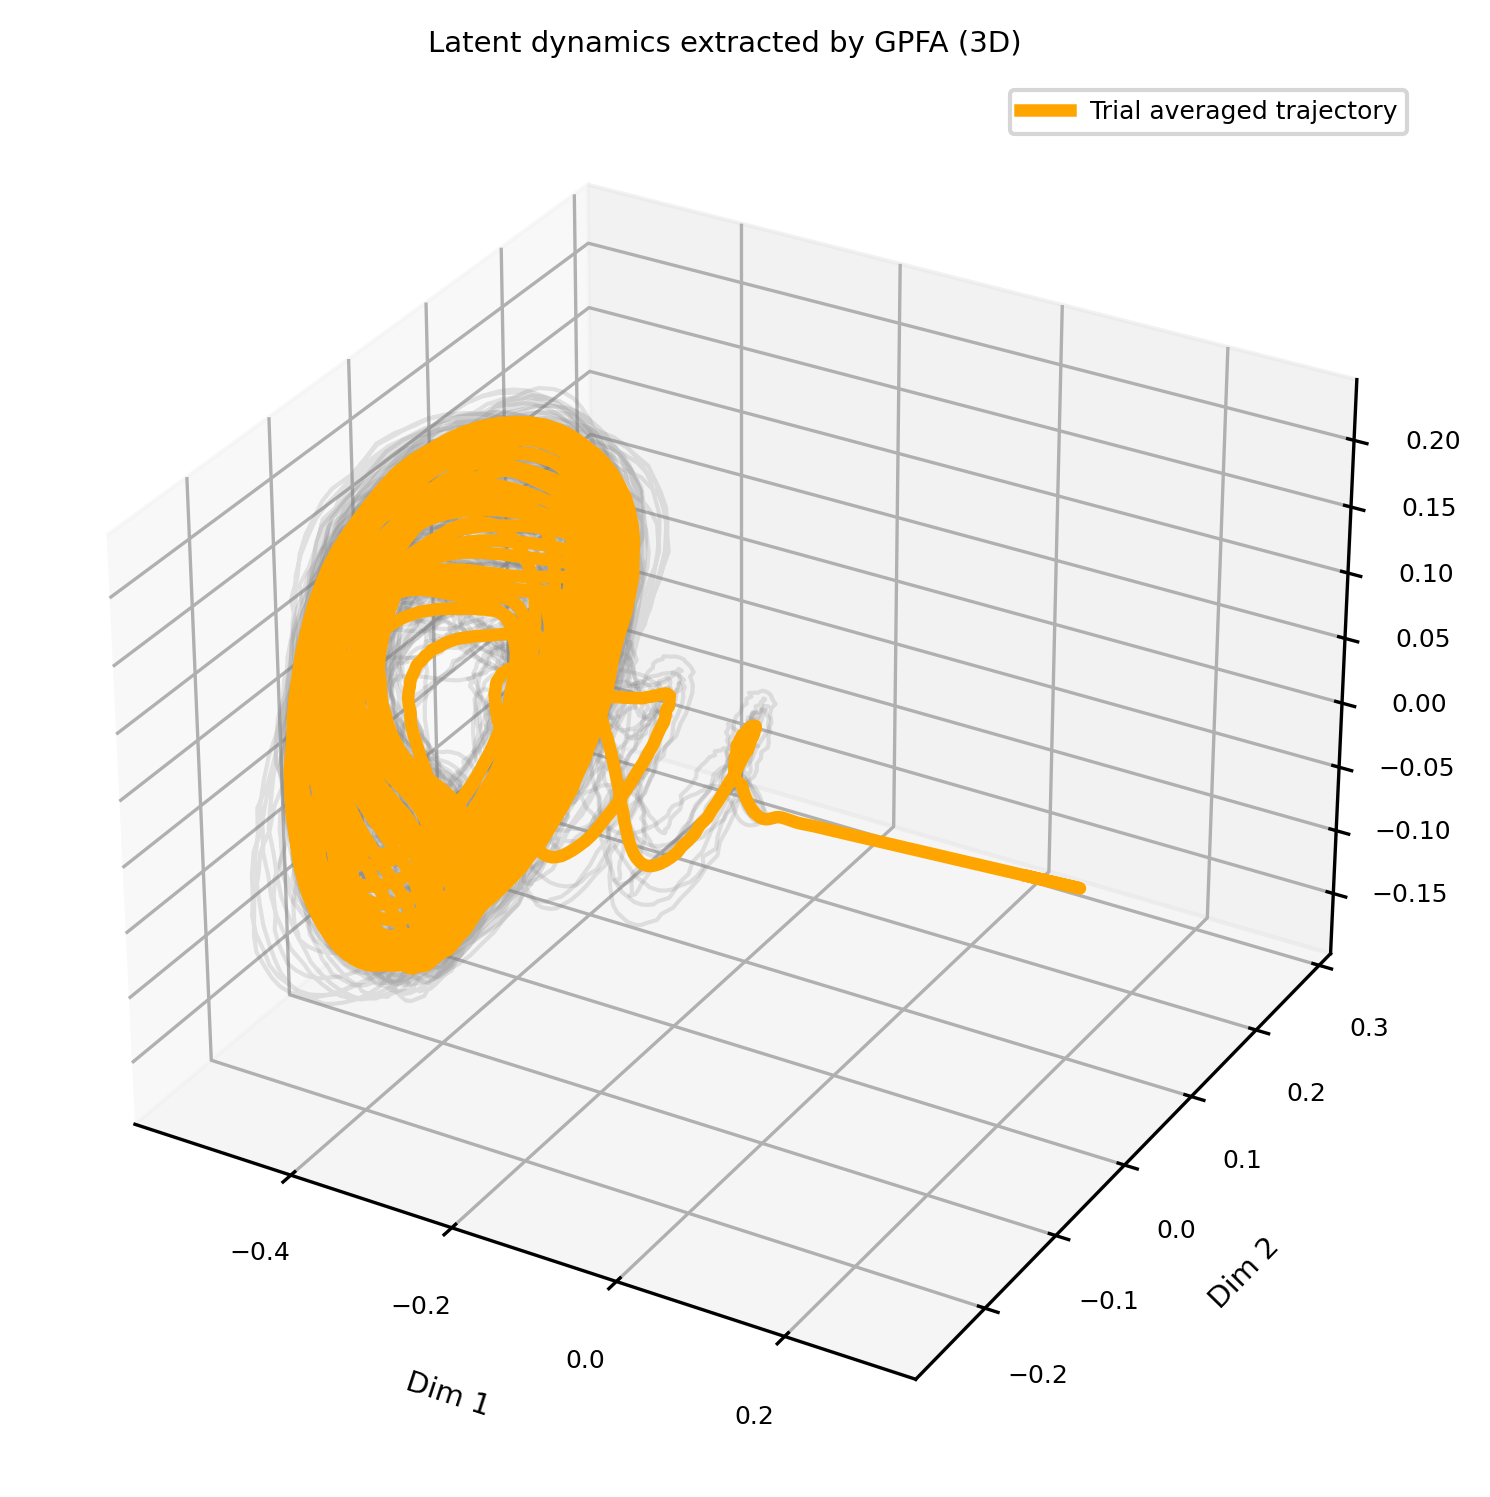

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection

# Example parameters (adjust as in your original code)
linewidth_single_trial = 1
color_single_trial = "gray"
alpha_single_trial = 0.2
linewidth_trial_average = 3
color_trial_average = "orange"

# Create 3D figure
fig = plt.figure(figsize=(7, 5))
ax3 = fig.add_subplot(111, projection='3d')

ax3.set_title('Latent dynamics extracted by GPFA (3D)')
ax3.set_xlabel('Dim 1')
ax3.set_ylabel('Dim 2')
ax3.set_zlabel('Dim 3')

# single trial trajectories
for single_trial_trajectory in trajectories:
    ax3.plot(
        single_trial_trajectory[0],
        single_trial_trajectory[1],
        single_trial_trajectory[2],
        '-', lw=linewidth_single_trial,
        c=color_single_trial,
        alpha=alpha_single_trial
    )

# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax3.plot(
    average_trajectory[0],
    average_trajectory[1],
    average_trajectory[2],
    '-', lw=linewidth_trial_average,
    c=color_trial_average,
    label='Trial averaged trajectory'
)

ax3.legend()
plt.tight_layout()
plt.show()

In [154]:
average_trajectory

array([[-4.65386024e-01, -4.65883125e-01, -4.65787592e-01, ...,
         2.31550107e-01,  2.31523873e-01,  2.31497420e-01],
       [ 5.87785775e-02,  6.41414455e-02,  6.96262289e-02, ...,
        -3.09723700e-05, -3.81746114e-05, -4.62733831e-05],
       [-4.47837042e-02, -4.21599063e-02, -3.87631924e-02, ...,
         3.59162109e-04,  3.62559977e-04,  3.66498709e-04]],
      shape=(3, 8000))

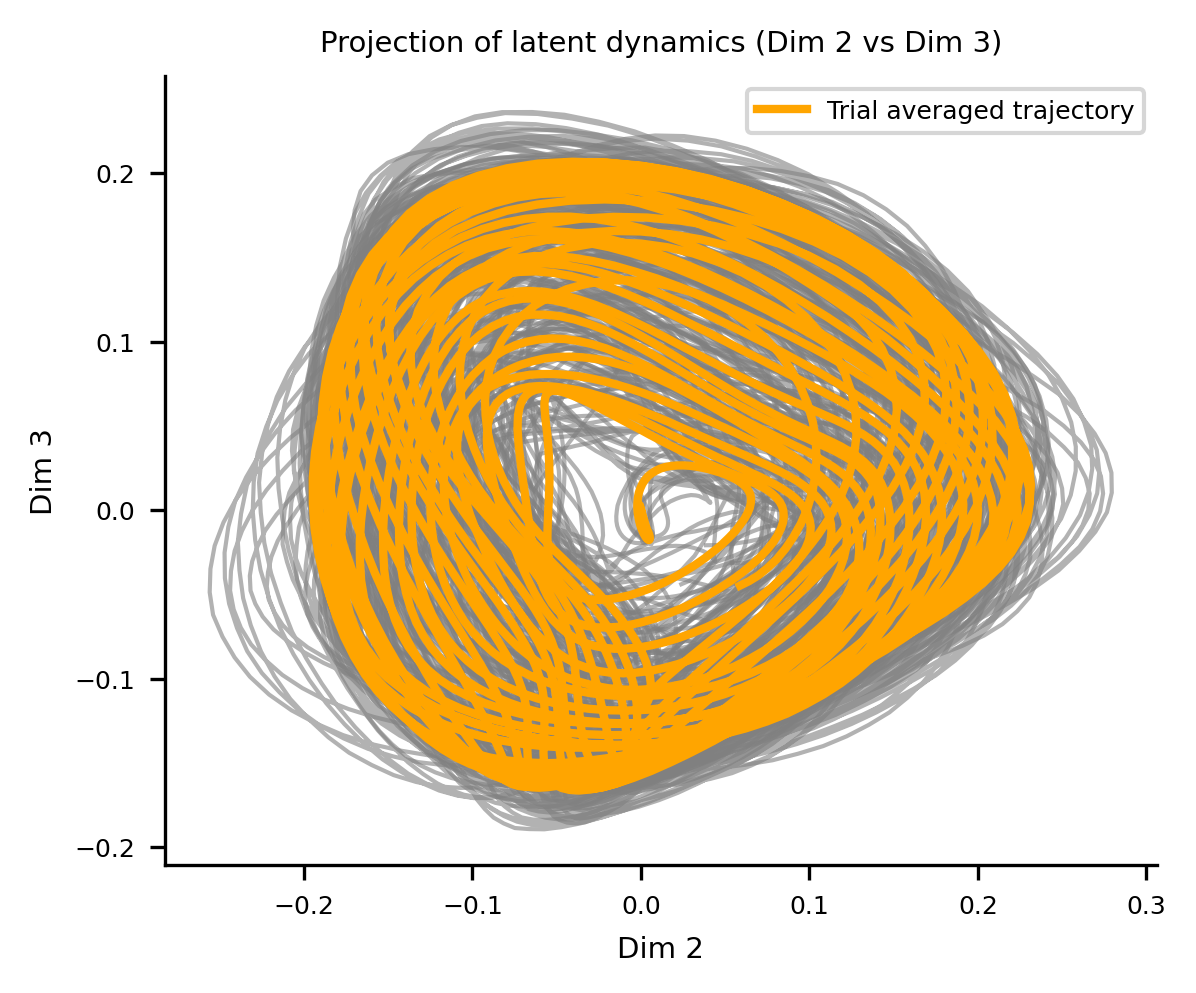

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Example parameters (adjust as needed)
linewidth_single_trial = 1
color_single_trial = "gray"
alpha_single_trial = 0.6
linewidth_trial_average = 2
color_trial_average = "Orange"

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.set_title('Projection of latent dynamics (Dim 2 vs Dim 3)')
ax.set_xlabel('Dim 2')
ax.set_ylabel('Dim 3')
ax.set_aspect(1)

# single trial trajectories
for single_trial_trajectory in trajectories:
    ax.plot(
        single_trial_trajectory[1],  # Dim 2
        single_trial_trajectory[2],  # Dim 3
        '-', lw=linewidth_single_trial,
        c=color_single_trial,
        alpha=alpha_single_trial
    )

# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax.plot(
    average_trajectory[1],  # Dim 2
    average_trajectory[2],  # Dim 3
    '-', lw=linewidth_trial_average,
    c=color_trial_average,
    label='Trial averaged trajectory', alpha=1
)

ax.legend()
plt.tight_layout()
plt.show()

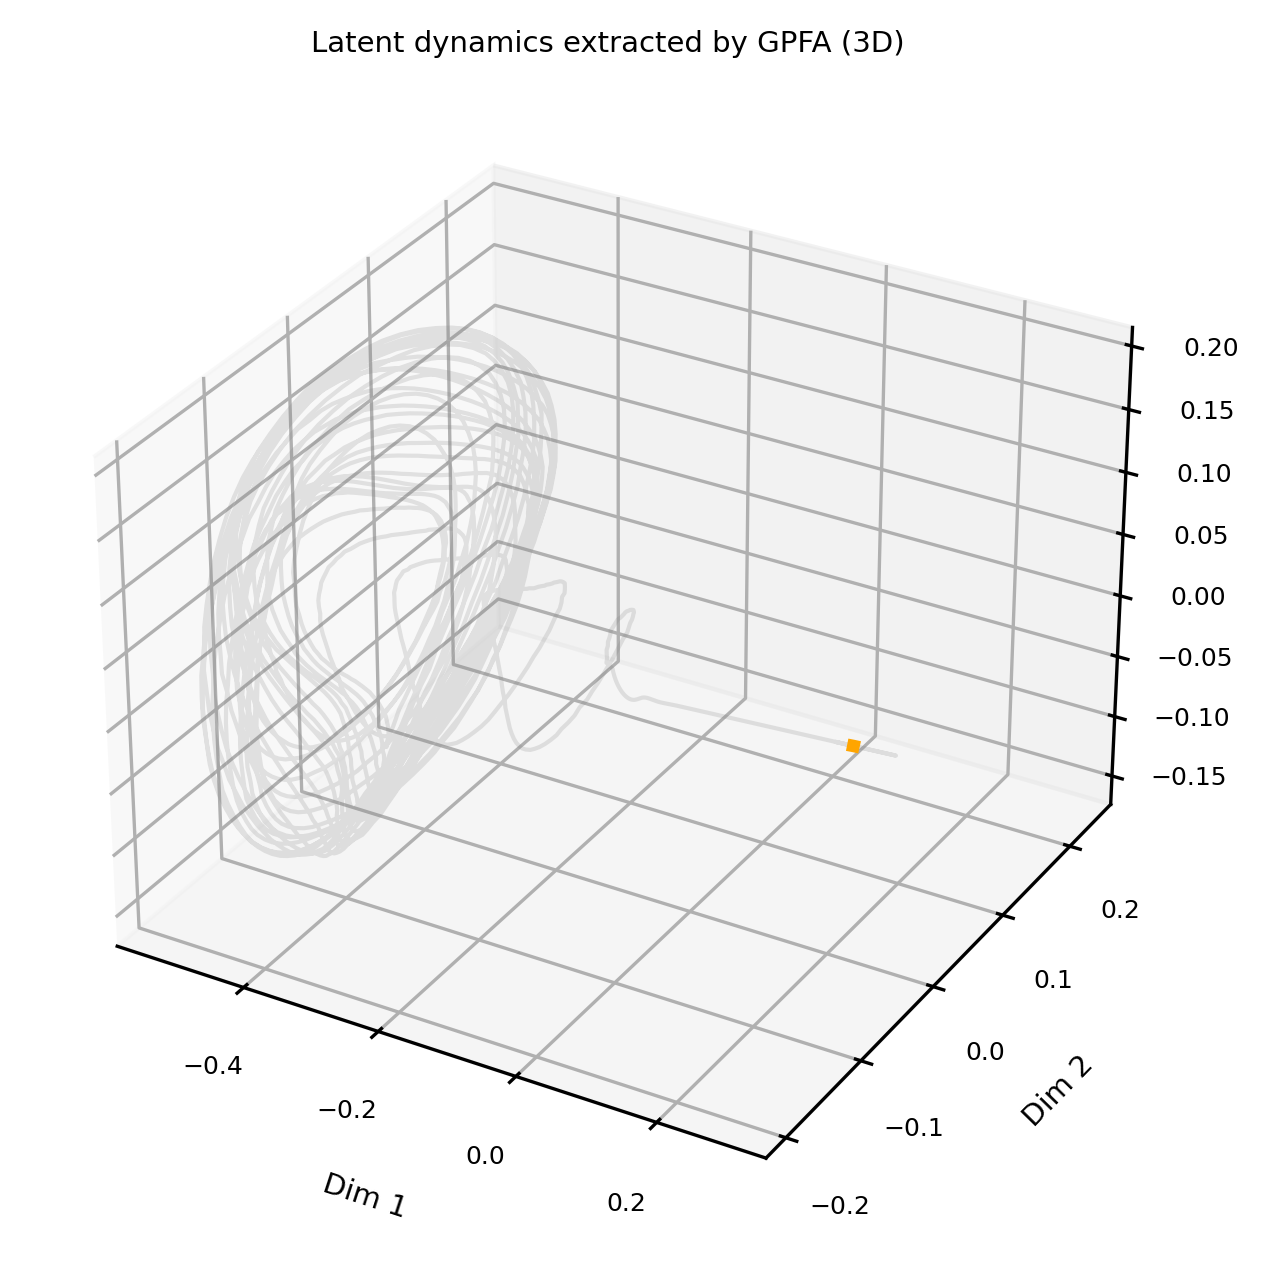

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Parameters
linewidth_single_trial = 1
color_single_trial = "gray"
alpha_single_trial = 0.2
linewidth_trial_average = 2
color_trial_average = "orange"
tail_length = 10   # how many points behind the head to highlight

# Example: use your average trajectory as the main one
trajectory = np.mean(trajectories, axis=0)  # shape (3, T)
x, y, z = trajectory[0], trajectory[1], trajectory[2]

# Create figure
fig = plt.figure(figsize=(7, 5))
ax3 = fig.add_subplot(111, projection='3d')
ax3.set_title('Latent dynamics extracted by GPFA (3D)')
ax3.set_xlabel('Dim 1')
ax3.set_ylabel('Dim 2')
ax3.set_zlabel('Dim 3')

# Plot the full trajectory in background (faint gray)
ax3.plot(x, y, z, '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)

# Dynamic elements: a moving "head" + short tail
(head_line,) = ax3.plot([], [], [], '-', lw=3, c=color_trial_average, alpha=1)

def init():
    head_line.set_data([], [])
    head_line.set_3d_properties([])
    return (head_line,)

def update(frame):
    start = max(0, frame - tail_length)
    head_line.set_data(x[start:frame+1], y[start:frame+1])
    head_line.set_3d_properties(z[start:frame+1])
    return (head_line,)

ani = FuncAnimation(fig, update, frames=len(x), init_func=init,
                    blit=True, interval=50)

# Save the animation (requires ffmpeg installed)
writer = FFMpegWriter(fps=60, metadata=dict(artist='Me'), bitrate=1800)
ani.save("latent_dynamics.mp4", writer=writer)

plt.show()

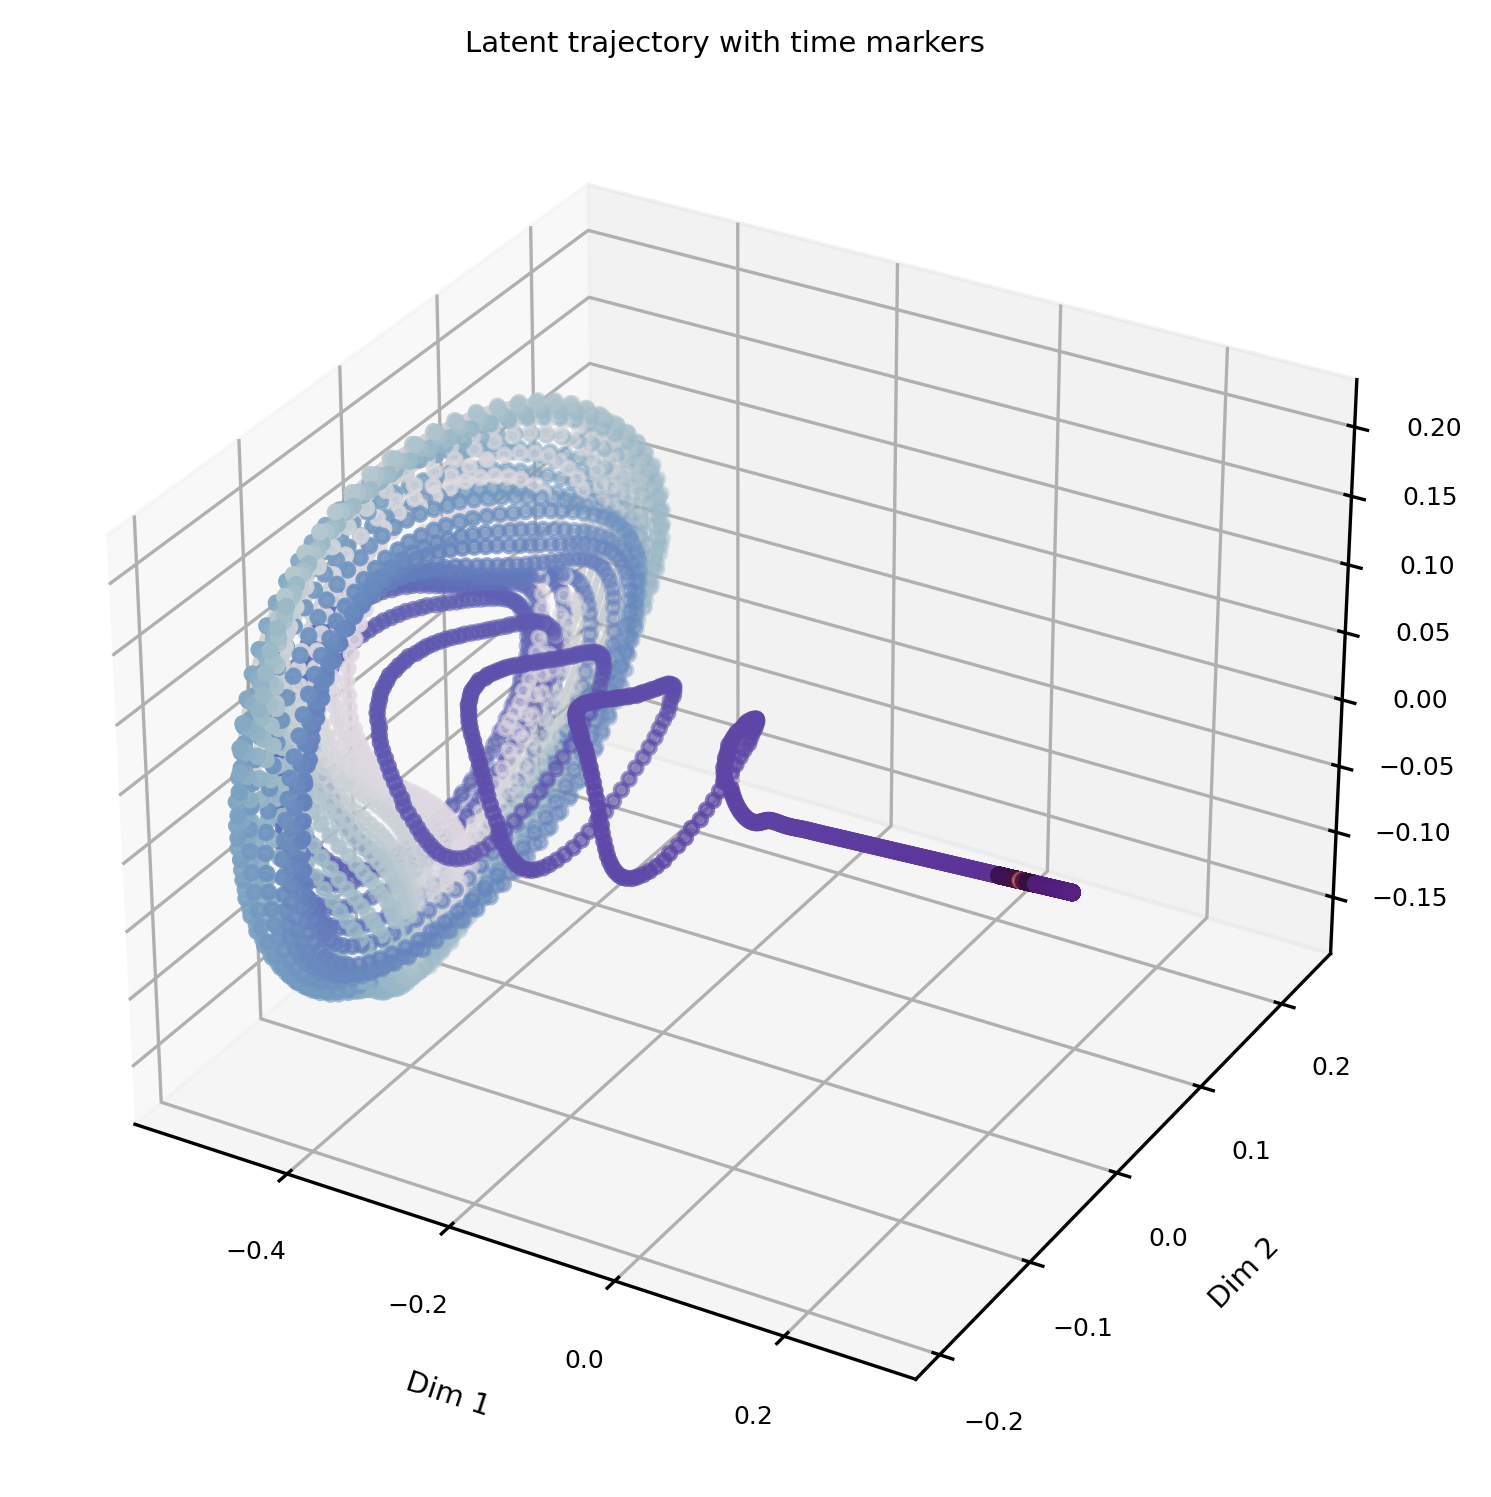

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Example trajectory (3 dims, T steps)
traj = np.mean(trajectories, axis=0)
x, y, z = traj

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

# faint continuous line
ax.plot(x, y, z, '-', color='gray', alpha=0.3)

# overlay time markers every 20 steps
step = 1
ax.scatter(x[::step], y[::step], z[::step], c=np.arange(0, len(x), step),
           cmap='twilight', s=10)

ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")
ax.set_title("Latent trajectory with time markers")
plt.tight_layout()
plt.show()

In [160]:
from elephant.spike_train_synchrony import spike_contrast

spike_contrast(spkt_base[0], t_start=0* pq.ms, t_stop=T* pq.ms)

np.float64(0.5)

In [192]:
import numpy as np
import quantities as pq
from elephant.spike_train_generation import homogeneous_poisson_process
from elephant.spike_train_synchrony import spike_contrast
import viziphant
%matplotlib inline
np.random.seed(24)

spkt_base = [convert_to_spiketrains(spike_train_base.astype(np.int32), T=T) for spike_train_base in trials]

spiketrains = spkt_base[0]
synchrony, trace = spike_contrast(spiketrains, return_trace=True, min_bin=0.25*pq.ms)
#viziphant.spike_train_synchrony.plot_spike_contrast(trace,
#     spiketrains=spiketrains, c='gray', s=1)
#plt.show()

In [193]:
len(trace.synchrony)


75

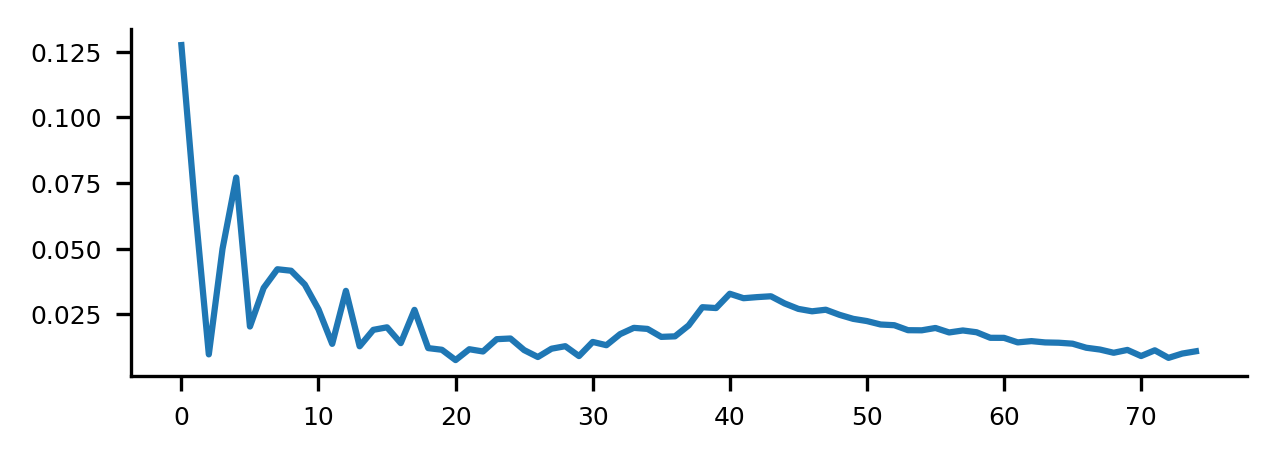

In [194]:
plt.plot(trace.synchrony)